In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
%load_ext autoreload
%autoreload 2

/home/krzysiek/anaconda3/envs/detection/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [3]:
import utils
import nets
import flow_layers as fl

In [4]:
batch_size = 64
train_dataset = utils.numpy_array_to_dataset(array=x_train, batch_size=batch_size)

In [5]:
x_train_samples = train_dataset.make_one_shot_iterator().get_next()

In [6]:
x_train_samples = tf.reshape(x_train_samples, [batch_size, 28, 28, 1])
x_train_samples = tf.image.resize_bilinear(x_train_samples, size=(32, 32))
x_train_samples

<tf.Tensor 'ResizeBilinear:0' shape=(64, 32, 32, 1) dtype=float32>

In [7]:
tf.set_random_seed(0)
sess = tf.InteractiveSession()

In [8]:
x_train_samples.eval().shape, x_train_samples.eval().max()

((64, 32, 32, 1), 1.0)

In [9]:
layers, actnorm_layers = nets.create_simple_flow(num_steps=1, num_scales=3)
images = x_train_samples
flow = fl.InputLayer(images)
model_flow = fl.ChainLayer(layers)
output_flow = model_flow(flow, forward=True)

LogitifyImage/Forward/                  : x=[64, 32, 32, 1]	z=[None]	logdet=[64]
SqueezingLayer/Forward/Scale1           : x=[64, 16, 16, 4]	z=[None]	logdet=[64]
ActnormBiasLayer/Forward/               : x=[64, 16, 16, 4]	z=[None]	logdet=[64]
ActnormScaleLayer/Forward/              : x=[64, 16, 16, 4]	z=[None]	logdet=[64]
ChainLayer/Forward/                     : x=[64, 16, 16, 4]	z=[None]	logdet=[64]
ActnormLayer/Forward/                   : x=[64, 16, 16, 4]	z=[None]	logdet=[64]
InvertibleConv1x1Layer/Forward/         : x=[64, 16, 16, 4]	z=[None]	logdet=[64]
AffineCouplingLayer/Forward/            : x=[64, 16, 16, 4]	z=[None]	logdet=[64]
ChainLayer/Forward/Step1                : x=[64, 16, 16, 4]	z=[None]	logdet=[64]
ChainLayer/Forward/Scale1               : x=[64, 16, 16, 4]	z=[None]	logdet=[64]
FactorOutLayer/Forward/Scale1           : x=[64, 16, 16, 2]	z=[64, 16, 16, 2]	logdet=[64]
SqueezingLayer/Forward/Scale2           : x=[64, 8, 8, 8]	z=[64, 8, 8, 8]	logdet=[64]
ActnormBiasLay

In [10]:
y, logdet, z = output_flow
output_flow

(<tf.Tensor 'ChainLayer/outputs/x:0' shape=(64, 4, 4, 8) dtype=float32>,
 <tf.Tensor 'ChainLayer/outputs/lodget:0' shape=(64,) dtype=float32>,
 <tf.Tensor 'ChainLayer/outputs/z:0' shape=(64, 4, 4, 56) dtype=float32>)

In [11]:
tfd = tf.contrib.distributions

y_flatten = tf.reshape(y, [batch_size, -1])
z_flatten = tf.reshape(z, [batch_size, -1])

prior_y = tfd.MultivariateNormalDiag(loc=tf.zeros_like(y_flatten))
prior_z = tfd.MultivariateNormalDiag(loc=tf.zeros_like(z_flatten))

log_prob_y =  prior_y.log_prob(y_flatten)
log_prob_z =  prior_z.log_prob(z_flatten)

In [12]:
loss = log_prob_y + log_prob_z + logdet
loss = - tf.reduce_mean(loss)

In [13]:
trainable_variables = tf.trainable_variables() 
l2_reg = 0.001 
l2_loss = l2_reg * tf.add_n([ tf.nn.l2_loss(v) for v in trainable_variables])

In [16]:
sess.run(tf.global_variables_initializer())

In [17]:
total_loss = l2_loss + loss

In [18]:
l2_loss.eval(), loss.eval()

(0.061281946, 13072.325)

In [19]:
sample_y_flatten = prior_y.sample()
sample_y = tf.reshape(sample_y_flatten, y.shape.as_list())
sample_z = tf.reshape(prior_z.sample(), z.shape.as_list())
sampled_logdet = prior_y.log_prob(sample_y_flatten)

In [20]:
inverse_flow = sample_y, sampled_logdet, sample_z
sampled_flow = model_flow(inverse_flow, forward=False)

FactorOutLayer/Backward/Scale3          : y=[64, 4, 4, 16]	z=[64, 4, 4, 48]	logdet=[64]
AffineCouplingLayer/Backward/           : y=[64, 4, 4, 16]	z=[64, 4, 4, 48]	logdet=[64]
InvertibleConv1x1Layer/Backward/        : y=[64, 4, 4, 16]	z=[64, 4, 4, 48]	logdet=[64]
ActnormScaleLayer/Backward/             : y=[64, 4, 4, 16]	z=[64, 4, 4, 48]	logdet=[64]
ActnormBiasLayer/Backward/              : y=[64, 4, 4, 16]	z=[64, 4, 4, 48]	logdet=[64]
ChainLayer/Backward/                    : y=[64, 4, 4, 16]	z=[64, 4, 4, 48]	logdet=[64]
ActnormLayer/Backward/                  : y=[64, 4, 4, 16]	z=[64, 4, 4, 48]	logdet=[64]
ChainLayer/Backward/Step1               : y=[64, 4, 4, 16]	z=[64, 4, 4, 48]	logdet=[64]
ChainLayer/Backward/Scale3              : y=[64, 4, 4, 16]	z=[64, 4, 4, 48]	logdet=[64]
SqueezingLayer/Backward/Scale3          : y=[64, 8, 8, 4]	z=[64, 8, 8, 12]	logdet=[64]
FactorOutLayer/Backward/Scale2          : y=[64, 8, 8, 8]	z=[64, 8, 8, 8]	logdet=[64]
AffineCouplingLayer/Backward/      

In [21]:
x_flow_sampled, _, _ = sampled_flow

In [22]:
x_flow_sampled.eval().shape

(64, 32, 32, 1)

In [23]:
optimizer = tf.train.AdamOptimizer(0.0001)
train_op = optimizer.minimize(total_loss)

In [24]:
sess.run(tf.global_variables_initializer())
nets.initialize_actnorms(
    sess,
    feed_dict_fn=lambda: None,
    actnorm_layers=actnorm_layers,
    num_steps=50,
)

100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


In [25]:
metrics = utils.Metrics(100, metrics_tensors={"total_loss": total_loss, "loss": loss, "l2_loss": l2_loss})
plot_metrics_hook = utils.PlotMetricsHook(metrics, step=100)

In [28]:
sess.run(train_op)

In [29]:
total_loss.eval()

-3156.1665

 10%|▉         | 99/1000 [00:03<00:32, 27.31it/s]

total_loss -3613.711
loss -3613.8335
l2_loss 0.122443706


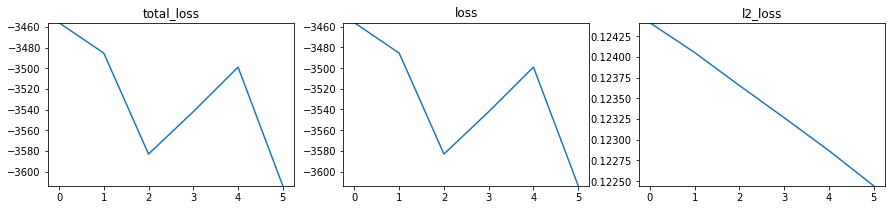

 20%|█▉        | 198/1000 [00:07<00:30, 26.15it/s]

total_loss -3548.7666
loss -3548.8887
l2_loss 0.12204757


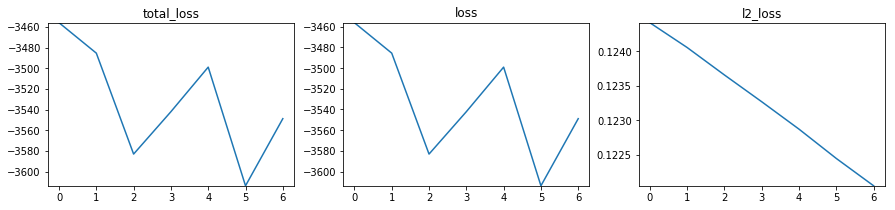

 30%|██▉       | 297/1000 [00:11<00:24, 29.24it/s]

total_loss -3564.893
loss -3565.0146
l2_loss 0.12164413


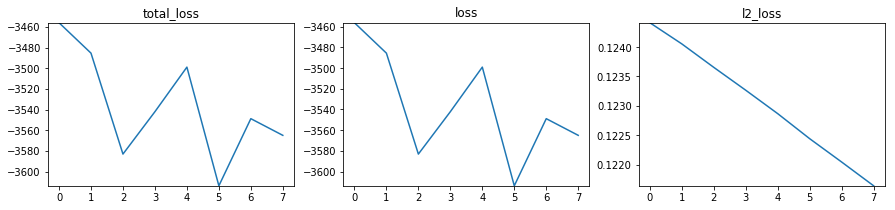

 40%|███▉      | 398/1000 [00:15<00:21, 28.58it/s]

total_loss -3548.6633
loss -3548.7847
l2_loss 0.12126162


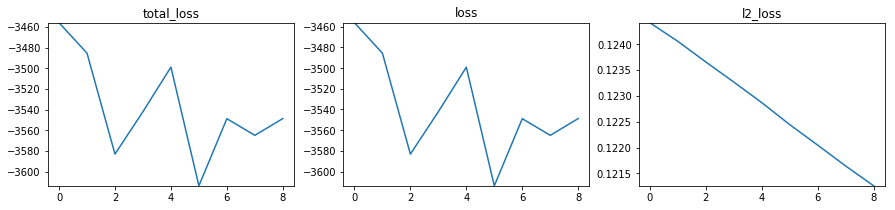

 50%|████▉     | 497/1000 [00:18<00:17, 29.28it/s]

total_loss -3628.9368
loss -3629.0576
l2_loss 0.12088309


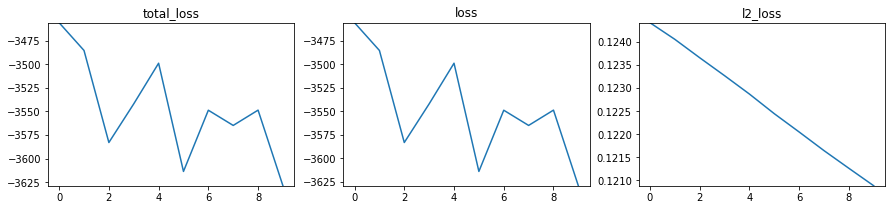

 60%|█████▉    | 599/1000 [00:22<00:14, 28.04it/s]

total_loss -3625.1953
loss -3625.316
l2_loss 0.12050309


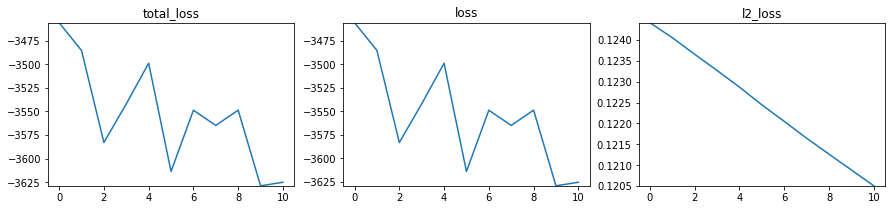

 70%|██████▉   | 698/1000 [00:26<00:10, 28.04it/s]

total_loss -3581.1978
loss -3581.3179
l2_loss 0.12013705


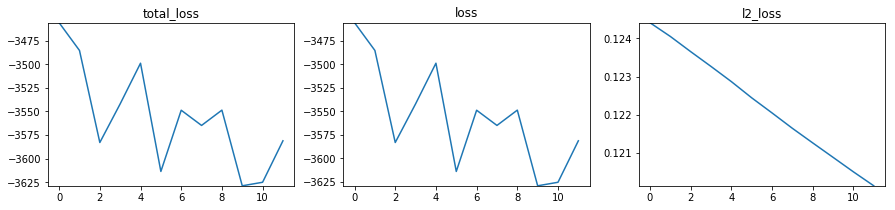

 80%|███████▉  | 799/1000 [00:30<00:06, 29.35it/s]

total_loss -3550.487
loss -3550.607
l2_loss 0.11976813


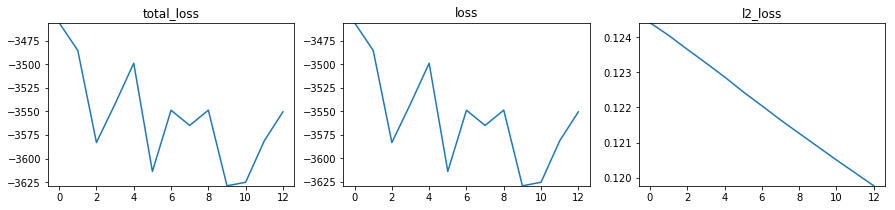

 90%|████████▉ | 899/1000 [00:33<00:03, 28.15it/s]

total_loss -3664.2632
loss -3664.3826
l2_loss 0.11942733


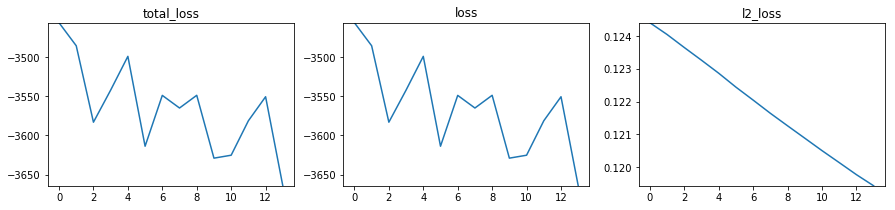

100%|█████████▉| 998/1000 [00:37<00:00, 28.76it/s]

total_loss -3682.7134
loss -3682.8325
l2_loss 0.11908427


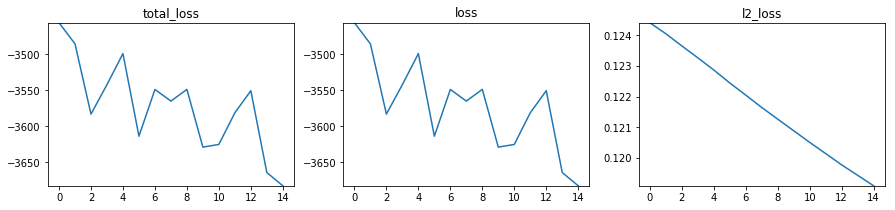

100%|██████████| 1000/1000 [00:38<00:00, 26.31it/s]


In [31]:
utils.trainer(sess, 1000, train_op=train_op, feed_dict_fn=lambda: None, metrics=[metrics], hooks=[plot_metrics_hook])

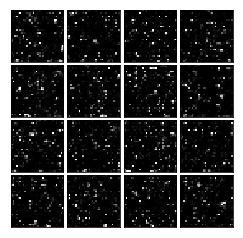

In [34]:
x_samples_np = x_flow_sampled.eval()
utils.plot_4x4_grid(x_samples_np, shape=[32, 32])